In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

def get_timestamp() -> str:
    timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    return timestamp

get_timestamp()


from tensorflow_addons.optimizers import AdamW

In [2]:
# data_dir = Path("./crop/")

# # Get list of all the images
# images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
# # labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
# for img in images:
# #     print(img.split(os.path.sep)[-1].split(".jpg")[0])
#     print(img.split(os.path.sep)[-1].split(".jpg")[0][5:])

In [27]:
data_dir = Path("./crop/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0][5:] for img in images]
characters = set(char for label in labels for char in label)
characters = set(sorted(list(characters)))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 1
# Desired image dimensions
img_width = 512
img_height = 64
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  239
Number of labels found:  239
Number of unique characters:  26
Characters present:  {'T', 'O', 'Z', 'M', 'E', 'I', 'N', 'X', 'D', 'Q', 'W', 'S', 'R', 'C', 'J', 'A', 'K', 'F', 'Y', 'V', 'L', 'U', 'B', 'H', 'P', 'G'}


In [28]:
char2id = {}
id2char = {}
for i,x in enumerate(list(characters)):
    char2id[x] = i
    
print(char2id)
for i,x in enumerate(list(characters)):
    id2char[i] = x
    
# print(id2char)

def char_to_num(char):
#     res=[]
    res = np.ones(15) - 2
    for i,c in enumerate(char):
#         print(c)
#         res.append(char2id[c])
        res[i] = char2id[c]
    return res

def num_to_char(num):
    res = []
    for n in num.numpy():
        if n in id2char.keys():
            res.append(id2char[n])
        else:
            res.append('?')
    return res

{'T': 0, 'O': 1, 'Z': 2, 'M': 3, 'E': 4, 'I': 5, 'N': 6, 'X': 7, 'D': 8, 'Q': 9, 'W': 10, 'S': 11, 'R': 12, 'C': 13, 'J': 14, 'A': 15, 'K': 16, 'F': 17, 'Y': 18, 'V': 19, 'L': 20, 'U': 21, 'B': 22, 'H': 23, 'P': 24, 'G': 25}


In [29]:

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images) 
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train[0:1], x_valid[0:1], y_train[0:1], y_valid[0:1]



# Splitting data into training and validation sets
x_train, x_valid, c_train, c_valid = split_data(np.array(images), np.array(labels))

y_train=[]
for i in c_train:
    y_train.append(char_to_num(i))
# y_train = np.array(y_train,dtype=np.int32)
# y_valid=[]
# for i in c_valid:
#     y_valid.append(char_to_num(i))
# y_valid = np.array(y_valid,dtype=np.int32)
# y_train


y_valid=[]
for i in c_valid:
#     break
    y_valid.append(char_to_num(i))




In [37]:
@tf.function
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
#     img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
#     label = char_to_label(label)
#     label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) -1
    # 7. Return a dict as our model is expecting two inputs
    lb_len = tf.reduce_sum(tf.cast(tf.not_equal(label, -1), tf.int64))
#     input_len = tf.math
#     return {"image": img, "label": label, "label_len":lb_len, "input_len":input_len}
    return {"image": img, "label": label, "label_len": lb_len}

In [7]:
# img_path = x_train[0]
# label = y_train[0]
# print(img_path)
# img = tf.io.read_file(img_path)
# # 2. Decode and convert to grayscale
# img = tf.io.decode_png(img, channels=3)
# # 3. Convert to float32 in [0, 1] range
# img = tf.image.convert_image_dtype(img, tf.float32)
# w,h = img.shape[0],img.shape[1]
# # 4. Resize to the desired size
# #     img = tf.image.resize(img, [img_height, img_width])
# # 5. Transpose the image because we want the time
# # dimension to correspond to the width of the image.
# #     img = tf.transpose(img, perm=[1, 0, 2])
# # 6. Map the characters in label to numbers
# #     label = char_to_label(label)
# #     label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) -1
# # 7. Return a dict as our model is expecting two inputs
# lb_len = tf.reduce_sum(tf.cast(tf.not_equal(label, -1), tf.int64))
# input_len = w // int(h // 4)


In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

[23.  1. 21. 11.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
tf.Tensor(5, shape=(), dtype=int64)
HOUSE??????????


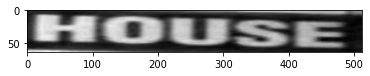

In [39]:
# _, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    label_len = batch["label_len"]
    for i in range(1):
        img = (images[i]).numpy().astype("float32")
#         print(labels[i])
        print(labels[i].numpy())
        print(label_len[i])
        label = ''.join(num_to_char(labels[i]))
        print(label)
        plt.imshow(img[:, :, 0], cmap="gray")

plt.show()

[23.  1. 21. 11.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
tf.Tensor(5, shape=(), dtype=int64)
HOUSE??????????


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

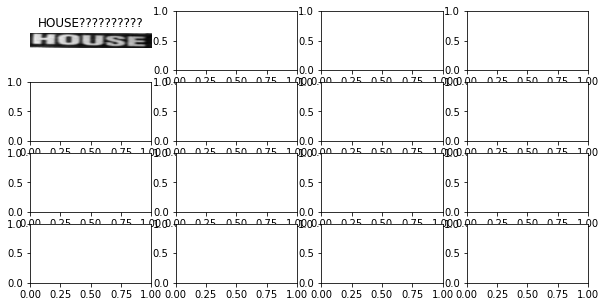

In [40]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    label_len = batch["label_len"]
    for i in range(16):
        img = (images[i]).numpy().astype("float32")
#         print(labels[i])
        print(labels[i].numpy())
        print(label_len[i])
        label = ''.join(num_to_char(labels[i]))
        print(label)
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
label_len[0]

In [15]:
config = {
#     "alpha": 1.0,
#     "minimalistic": True,
    "weights": "imagenet",
    "weights": None,
    "include_top": False
}
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred,label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(label_length, dtype="int64")
#         label_length = tf.cast(label_length, tf.int32)
        print(label_length)
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length[:,tf.newaxis])
        self.add_loss(loss)
        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_height,img_width, 3), name="image", dtype="float32"
#         shape=(200, 64, 3), name="image", dtype="float32"
    )
    # rescale = layers.Rescaling(scale=1.0 / 255,offset=0)(input_img)
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    label_len = keras.Input(shape=(), dtype=tf.int64, name='label_len')
    # x = keras.applications.vgg19.VGG19(include_top=False,weights='imagenet', input_tensor=input_img).get_layer('block2_pool').output
    # # base = keras.applications.MobileNetV3Large(input_tensor=input_img, **config).get_layer('Conv').output
    # x = keras.applications.ResNet101(include_top=False, weights='imagenet', input_tensor=input_img).get_layer('conv2_block1_out').output
#     x = keras.applications.MobileNetV3Large(input_tensor=input_img, **config).get_layer('expanded_conv/Add').output
#     x  = keras.applications.resnet50.ResNet50(input_tensor=input_img, **config).get_layer('conv1_conv').output
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)
#     x = keras.layers.DepthwiseConv2D(32,(3,3),activation="relu",padding="same",kernel_initializer="he_normal")(x)

    # base = keras.applications.MobileNetV3Large(input_tensor=input_img,**config)
    # base = keras.applications.MobileNet(input_tensor=input_img, **config)

    # x = base.get_layer('Conv')(input_img)
    # x = base.get_layer('conv1').output
    

    # feature = base.get_layer('Conv').output

    # # First conv block
#     x = layers.Conv2D(
#         32,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv1",
#     )(x)
#     # x = layers.MaxPooling2D((2, 2), name="pool1")(x)

#     # # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
#     x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.MaxPooling2D((2, 2))(x)

    print(x)
    x = layers.Conv2D(32,(16,1),activation="relu",strides=1)(x)
    
    x = layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    # reshape
    # new_shape = ((img_width // 4), (img_height // 4) * 64)
    # x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # x = layers.Dense(64, activation="relu", name="dense1")(x)
    # x = layers.Dropout(0.2)(x)

    # RNNs
    # x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        27, activation="softmax", name="dense2"
    )(x)
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x,label_len)
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels,label_len], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(lr=0.0012, beta_1=0.9, beta_2=0.9, epsilon=1e-08, amsgrad=True) 
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 128, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
Tensor("Placeholder_2:0", shape=(None,), dtype=int64)
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 512, 3)] 0                                            
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 512, 64)  1792        image[0][0]                      
__________________________________________________________________________________________________
pool2 (MaxPooling2D)            (None, 32, 256, 64)  0           Conv2[0][0]                      
_____________________________________________________________

In [48]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred,label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(label_length, dtype="int64")
#         label_length = tf.cast(label_length, tf.int32)
#         print(label_length)
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length[:,tf.newaxis])
        self.add_loss(loss)
        # At test time, just return the computed predictions
        return y_pred

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_height,img_width, 3), name="image", dtype="float32"
#         shape=(200, 64, 3), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    label_len = keras.Input(shape=(), dtype=tf.int64, name='label_len')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
#     new_shape = ((img_width // 4), (img_height // 4) * 64)
#     x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    print(x)
#     x = layers.Conv2D(32,(16,1),activation="relu",strides=1)(x)
#     x = layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(x)
    
    x = layers.Conv2D(32,(16,1),activation="relu",strides=1)(x)
    x = layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(x)
    
    
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
#     x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
#     x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        27, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x,label_len)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels,label_len], outputs=output, name="ocr_model_v1"
    )
    
#     model = keras.models.Model(
#         inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
#     )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 128, 64), dtype=tf.float32, name=None), name='pool2/MaxPool:0', description="created by layer 'pool2'")
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 512, 3)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 512, 32)  896         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 32, 256, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  

In [59]:

filepath = get_timestamp() + '.ckpt'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

epochs = 40
early_stopping_patience = 20
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
#     callbacks=[early_stopping,checkpoint],
)

Epoch 1/40
1/1 [==============================] - 0s 101ms/step - loss: 0.2404 - val_loss: 144.9542
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.0492 - val_loss: 144.9650
Epoch 3/40
1/1 [==============================] - 0s 89ms/step - loss: 0.0340 - val_loss: 144.9744
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 0.0139 - val_loss: 144.9820
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 0.2681 - val_loss: 144.9863
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.6121 - val_loss: 144.9757
Epoch 7/40
1/1 [==============================] - 0s 91ms/step - loss: 0.1483 - val_loss: 144.9654
Epoch 8/40
1/1 [==============================] - 0s 90ms/step - loss: 0.0431 - val_loss: 144.9548
Epoch 9/40
1/1 [==============================] - 0s 94ms/step - loss: 0.1221 - val_loss: 144.9417
Epoch 10/40
1/1 [==============================] - 0s 89ms/step - loss: 0.0666 - val_loss: 144.9310
Epoch 11

(1, 64, 512, 3)


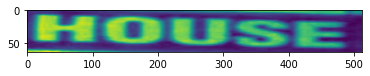

[13.]
['HOU?????????']


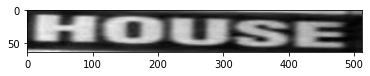

In [60]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, keras.layers.Softmax()(model.get_layer(name="dense2").output)
    # model.get_layer(name="image").input, model.get_layer(name="separable_conv2d_1").output
)
def decode_batch_predictions(pred):
#     input_len = np.ones(pred.shape[0]) * pred.shape[1]
    input_len = np.ones(pred.shape[0]) * 13
    # Use greedy search. For complex tasks, you can use beam search
    print(input_len)
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    plt.imshow(batch_images[0,...,0].numpy())
    plt.show()
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
#     print(pred.shape)
    print(pred_texts)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img
        title = f"Prediction: {pred_texts[i]}"
        plt.imshow(img, cmap="gray")
plt.show()